In [1]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv')
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
#zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
#zone_data_7_bottom = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 0]
#zone_data_6_bottom = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
#zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
#zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
#zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
#zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
#zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
#zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




        Status Application Creation Date Approved / Refused Date  \
4920  Recorded                09/04/2009              14/08/2009   
670   Recorded                23/04/2009              09/06/2009   
8771  Recorded                23/04/2009              13/05/2009   
5222  Recorded                23/04/2009              13/05/2009   
4134  Recorded                05/05/2009              27/05/2009   
...        ...                       ...                     ...   
2514  Recorded                02/04/2024              11/04/2024   
3385  Recorded                04/04/2024              11/04/2024   
5773  Recorded                11/04/2024              16/04/2024   
6748  Recorded                11/04/2024              12/04/2024   
3356  Recorded                12/04/2024              16/04/2024   

     Recorded / Rejected Date Water Share ID Water System Source Reliability  \
4920               12/10/2009      WEE****70            Goulburn        High   
670                03/0

# ARIMAX

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


WATERTEMP = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv', parse_dates=['Time'], index_col='Time')
#TURBIDITY = pd.read_csv(Turbidity_temp_file_path, parse_dates=['Time'], index_col='Time')
#AIRTEMP = pd.read_csv(DryAir_temp_file_path, parse_dates=['Time'], index_col='Time')
RAINFALL = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanRainfall.csv', parse_dates=['Time'], index_col='Time')
WATERCOURSE = pd.read_csv('../GET_WATER_DATA_ONLINE/DailyMeanWaterCourseDischarge.csv', parse_dates=['Time'], index_col='Time')
#ELECTRICALCOND = pd.read_csv(EC_temp_file_path, parse_dates=['Time'], index_col='Time')

# ZONE DATA ARRAY AND NAMES OF ZONES
ZONEDATA = [zone_data_1A_top_sorted, zone_data_6_top_sorted, zone_data_7_top_sorted]
zone_names = ['Zone 1A', 'Zone 6', 'Zone 7']



from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Assuming 'principal component 1' as the target series
test_stationarity(ZONEDATA['principal component 1'])


In [3]:
# Combine exogenous data into a single DataFrame, aligning by date
# Exclude turbidity and aritemp, electric conductivity due to not enough data
exog_data = pd.concat(
    [WATERTEMP, 
     #TURBIDITY, 
     #AIRTEMP, 
     RAINFALL, 
     WATERCOURSE, 
     #ELECTRICALCOND
     ], axis=1)

# Assuming 'finalDf' and 'principal component 1' are already defined and correct
# Make sure 'finalDf' is also indexed by date

# Aligning exogenous data with finalDf
exog_data.index = pd.to_datetime(exog_data.index)

exog_data = exog_data.fillna(method='bfill').interpolate(method='time')
print(exog_data.shape)



exog_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace all inf/-inf with NaN
exog_data = exog_data.dropna(axis=1)
exog_data = exog_data.dropna(axis=0)
print(exog_data.shape)
print(exog_data)


(14000, 2487)
(14000, 2487)
                           2122518  2122711  2122713  2122725   215208  \
Time                                                                     
2010-01-01 00:00:00+10:00    21.14    22.95    20.19    22.99    17.86   
2010-01-01 00:30:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-01 02:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:00:00+10:00    21.14    23.28    20.19    23.20    17.86   
2010-01-02 00:30:00+10:00    21.14    22.54    20.19    19.27    17.86   
...                            ...      ...      ...      ...      ...   
2023-12-30 00:00:00+10:00     0.00    20.64    19.25    18.84 -9999.00   
2023-12-30 00:30:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:00:00+10:00     0.00    20.67    19.25    18.84 -9999.00   
2023-12-31 00:30:00+10:00     0.00    20.53    19.25    18.84 -9999.00   
2024-01-01 00:00:00+10:00     0.00    20.53    19.25    18.84 -9999.00   

         

In [4]:
# Convert index to datetime if it isn't already
exog_data.index = pd.to_datetime(exog_data.index)
# Remove time zone information from exog_data
exog_data.index = exog_data.index.tz_localize(None)
# Resample to daily frequency using the mean
exog_data_daily = exog_data.resample('D').mean()



# Create final DataFrames for each zone
final_dfs = []
for zone_data in ZONEDATA:
    # Create a copy of the zone data
    zone_df = zone_data.copy()
    
    # Assuming 'Create_date' is the column to align by
    zone_df['Create_date'] = pd.to_datetime(zone_df['Create_date'])
    zone_df.set_index('Create_date', inplace=True)
    
    final_dfs.append(zone_df)

print(final_dfs)


[               Status Application Creation Date Approved / Refused Date  \
Create_date                                                               
2009-04-09   Recorded                09/04/2009              14/08/2009   
2009-04-23   Recorded                23/04/2009              09/06/2009   
2009-04-23   Recorded                23/04/2009              13/05/2009   
2009-04-23   Recorded                23/04/2009              13/05/2009   
2009-05-05   Recorded                05/05/2009              27/05/2009   
...               ...                       ...                     ...   
2024-04-02   Recorded                02/04/2024              11/04/2024   
2024-04-04   Recorded                04/04/2024              11/04/2024   
2024-04-11   Recorded                11/04/2024              16/04/2024   
2024-04-11   Recorded                11/04/2024              12/04/2024   
2024-04-12   Recorded                12/04/2024              16/04/2024   

            Recorded / 

            Principal Component 1  Principal Component 2  \
Time                                                       
2010-01-01               0.559263              26.909625   
2010-01-02             -10.349802              13.928652   
2010-01-03             -16.981906               8.601545   
2010-01-04             -18.237293               9.168417   
2010-01-05             -18.939854               9.491767   
...                           ...                    ...   
2023-12-28              -3.541601               8.144014   
2023-12-29              -7.541435               8.566159   
2023-12-30              -9.789410               8.326155   
2023-12-31             -12.261539               8.728653   
2024-01-01             -13.093952               9.693901   

            Principal Component 3  Principal Component 4  \
Time                                                       
2010-01-01              -0.263760              23.269305   
2010-01-02               6.392669      

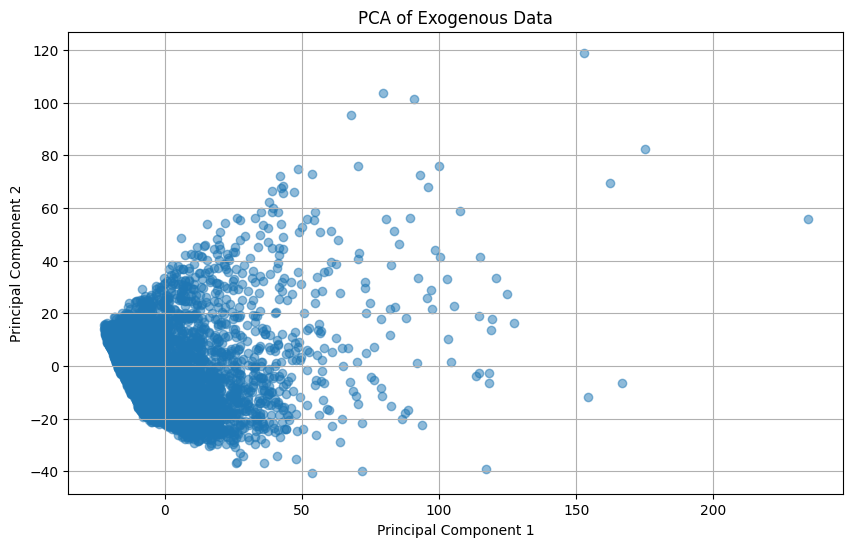

Principal Component 1: 15.92%
Principal Component 2: 9.37%
Principal Component 3: 6.72%
Principal Component 4: 5.42%
Principal Component 5: 3.70%
Principal Component 6: 2.89%
Principal Component 7: 2.40%
Principal Component 8: 1.96%
Principal Component 9: 1.74%
Principal Component 10: 1.69%
sum:  0.5181388068463084


In [5]:
# Standardize the data
scaler = StandardScaler()
exog_data_standardized = scaler.fit_transform(exog_data_daily)


# Number of principal components to keep
n_components = 10  # Adjust this number as needed

# Fit PCA model
pca = PCA(n_components)  # Number of components can be adjusted
principalComponents = pca.fit_transform(exog_data_standardized)

principal_component_labels = [f'Principal Component {i+1}' for i in range(n_components)]
combined_principal_df = pd.DataFrame(data=principalComponents, columns=principal_component_labels, index=exog_data_daily.index)
print(combined_principal_df)

plt.figure(figsize=(10, 6))
plt.scatter(combined_principal_df['Principal Component 1'], combined_principal_df['Principal Component 2'], alpha=0.5)
plt.title('PCA of Exogenous Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Display explained variance
explained_variance = pca.explained_variance_ratio_
for i, variance in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {variance * 100:.2f}%")
print("sum: ", sum(explained_variance))



In [6]:
# Create a list to store the NEW_PCA_COMBINED_DFs for each zone
new_pca_combined_dfs = []

# Iterate over each zone's final DataFrame
for zone_df in final_dfs:
    # Combine the PCA DataFrame with the 'Price Per ML ($)' column of the zone DataFrame
    new_pca_combined_df = combined_principal_df.join(zone_df['Price Per ML ($)'], how='inner')
    new_pca_combined_dfs.append(new_pca_combined_df)

# Print the NEW_PCA_COMBINED_DFs for each zone
for i, new_pca_combined_df in enumerate(new_pca_combined_dfs):
    print(f"NEW_PCA_COMBINED_DF for Zone {i+1}:")
    print(new_pca_combined_df)
    print()

NEW_PCA_COMBINED_DF for Zone 1:
            Principal Component 1  Principal Component 2  \
2010-01-04             -18.237293               9.168417   
2010-01-04             -18.237293               9.168417   
2010-01-04             -18.237293               9.168417   
2010-01-04             -18.237293               9.168417   
2010-01-05             -18.939854               9.491767   
...                           ...                    ...   
2023-12-21             -13.311171               8.836721   
2023-12-22             -13.179996              10.723847   
2023-12-22             -13.179996              10.723847   
2023-12-22             -13.179996              10.723847   
2023-12-22             -13.179996              10.723847   

            Principal Component 3  Principal Component 4  \
2010-01-04               7.795494              15.517740   
2010-01-04               7.795494              15.517740   
2010-01-04               7.795494              15.517740   
2010-01

# Sarimax with correct plotting time and splitting into test/train

## Is there seasonality? Lets check

## Plotting SARIMAX with ratio of training and test data

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21957D+00    |proj g|=  4.84416D-02


 This problem is unconstrained.



At iterate    5    f=  7.21216D+00    |proj g|=  9.80413D-02

At iterate   10    f=  7.20427D+00    |proj g|=  1.28732D-02

At iterate   15    f=  7.20339D+00    |proj g|=  5.28919D-03

At iterate   20    f=  7.20312D+00    |proj g|=  1.51360D-02

At iterate   25    f=  7.20297D+00    |proj g|=  4.21781D-03

At iterate   30    f=  7.20292D+00    |proj g|=  5.93805D-03

At iterate   35    f=  7.20246D+00    |proj g|=  1.71836D-02

At iterate   40    f=  7.20223D+00    |proj g|=  1.67613D-03

At iterate   45    f=  7.20220D+00    |proj g|=  2.06980D-03

At iterate   50    f=  7.20169D+00    |proj g|=  9.65383D-03

At iterate   55    f=  7.20149D+00    |proj g|=  1.65352D-03

At iterate   60    f=  7.20147D+00    |proj g|=  1.37453D-03

At iterate   65    f=  7.20147D+00    |proj g|=  4.88292D-03

At iterate   70    f=  7.20139D+00    |proj g|=  1.81159D-02

At iterate   75    f=  7.20108D+00    |proj g|=  2.11840D-02

At iterate   80    f=  7.20099D+00    |proj g|=  5.45374D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     91    128      1     0     0   5.522D-04   7.201D+00
  F =   7.2009518070411076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

Results for Zone 1A:
                               SARIMAX Results                                
Dep. Variable:       Price Per ML ($)   No. Observations:                 6987
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -50313.050
Date:                Wed, 15 May 2024   AIC                         100660.101
Time:                        22:24:54   BIC                         100776.579
Sample:                             0   HQIC                        100700.241
                               - 6987                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Principal Component 1      0.6707      0.923      0.727      0.467      -1.138       2.479
Principal Component 2     -0.6088      0.846     -0.719      0.472      -2

 This problem is unconstrained.



At iterate    5    f=  7.17941D+00    |proj g|=  7.75510D-03

At iterate   10    f=  7.17882D+00    |proj g|=  1.21446D-03

At iterate   15    f=  7.17873D+00    |proj g|=  4.89872D-03

At iterate   20    f=  7.17798D+00    |proj g|=  7.02831D-02

At iterate   25    f=  7.17703D+00    |proj g|=  8.25014D-02

At iterate   30    f=  7.17680D+00    |proj g|=  2.84054D-02

At iterate   35    f=  7.17674D+00    |proj g|=  1.19420D-02

At iterate   40    f=  7.17661D+00    |proj g|=  1.35823D-02

At iterate   45    f=  7.17533D+00    |proj g|=  2.17298D-01

At iterate   50    f=  7.17469D+00    |proj g|=  5.47101D-03

At iterate   55    f=  7.17450D+00    |proj g|=  3.55215D-02

At iterate   60    f=  7.17444D+00    |proj g|=  1.03215D-02

At iterate   65    f=  7.17443D+00    |proj g|=  2.96953D-03

At iterate   70    f=  7.17434D+00    |proj g|=  3.59135D-02

At iterate   75    f=  7.17395D+00    |proj g|=  1.01847D-02

At iterate   80    f=  7.17381D+00    |proj g|=  5.30548D-02

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

Results for Zone 6:
                               SARIMAX Results                                
Dep. Variable:       Price Per ML ($)   No. Observations:                 1859
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -13335.404
Date:                Wed, 15 May 2024   AIC                          26704.808
Time:                        22:25:53   BIC                          26798.772
Sample:                             0   HQIC                         26739.438
                               - 1859                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Principal Component 1      0.6645      1.476      0.450      0.652      -2.228       3.556
Principal Component 2      0.8203      1.320      0.621      0.534      -1.

 This problem is unconstrained.



At iterate    5    f=  7.63637D+00    |proj g|=  6.52519D-02

At iterate   10    f=  7.63339D+00    |proj g|=  1.33874D-03

At iterate   15    f=  7.63227D+00    |proj g|=  1.21184D-02

At iterate   20    f=  7.63131D+00    |proj g|=  1.43073D-03

At iterate   25    f=  7.63127D+00    |proj g|=  2.01912D-03

At iterate   30    f=  7.63108D+00    |proj g|=  2.25913D-03

At iterate   35    f=  7.63100D+00    |proj g|=  9.68192D-03

At iterate   40    f=  7.63051D+00    |proj g|=  6.57127D-03

At iterate   45    f=  7.62991D+00    |proj g|=  3.50363D-03

At iterate   50    f=  7.62980D+00    |proj g|=  1.29693D-03

At iterate   55    f=  7.62977D+00    |proj g|=  2.73650D-03

At iterate   60    f=  7.62965D+00    |proj g|=  6.84484D-03

At iterate   65    f=  7.62937D+00    |proj g|=  2.28917D-03

At iterate   70    f=  7.62918D+00    |proj g|=  4.62188D-03

At iterate   75    f=  7.62894D+00    |proj g|=  2.19268D-03

At iterate   80    f=  7.62879D+00    |proj g|=  3.11101D-03

At iter

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Results for Zone 7:
                               SARIMAX Results                                
Dep. Variable:       Price Per ML ($)   No. Observations:                 7232
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -55158.724
Date:                Wed, 15 May 2024   AIC                         110351.448
Time:                        22:29:27   BIC                         110468.512
Sample:                             0   HQIC                        110391.720
                               - 7232                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Principal Component 1     -1.0126      1.264     -0.801      0.423      -3.491       1.466
Principal Component 2      0.0309      1.144      0.027      0.978      -2.

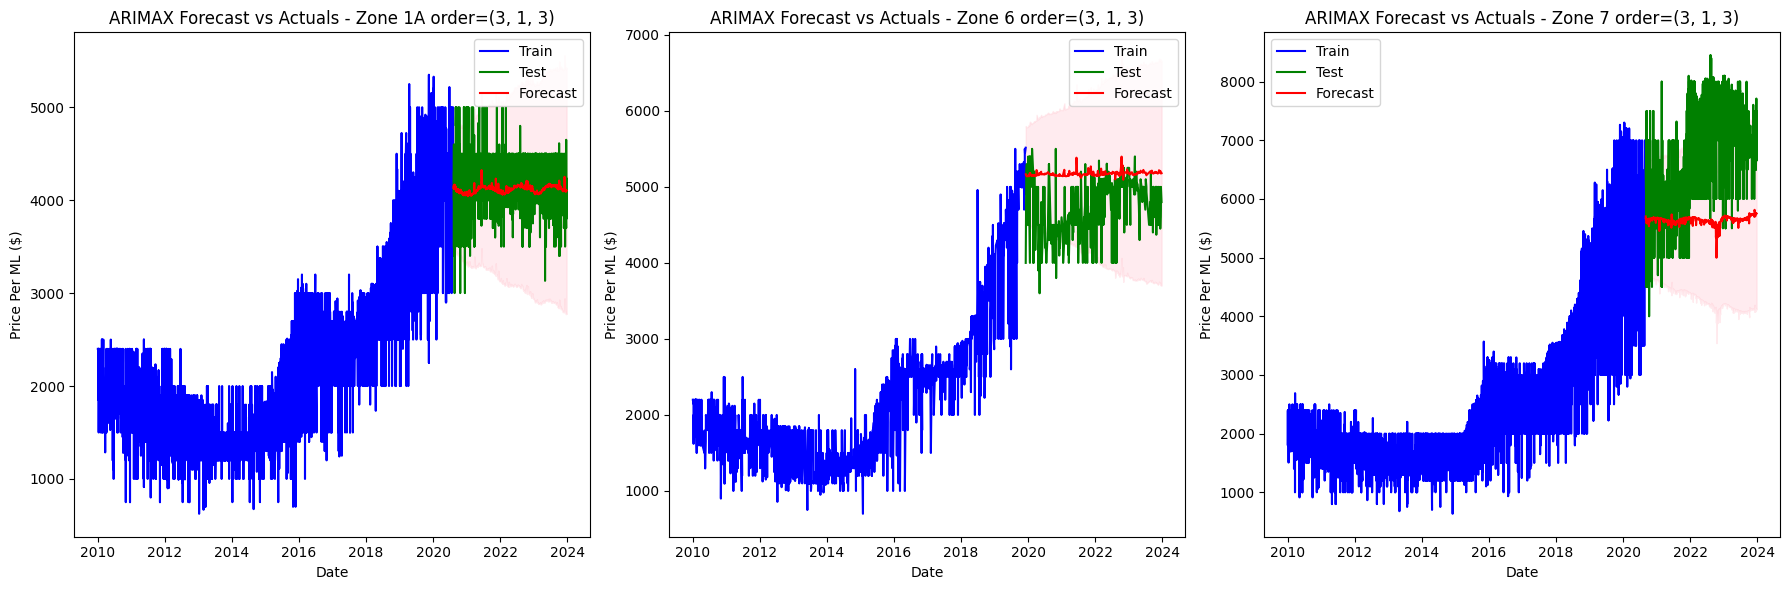

In [7]:
import math

# Get the number of zones
num_zones = len(new_pca_combined_dfs)

# Calculate the number of rows needed for the subplots
num_rows = math.ceil(num_zones / 3)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each zone's NEW_PCA_COMBINED_DF
for i, NEW_PCA_COMBINED_DF in enumerate(new_pca_combined_dfs):
    # Convert back to datetime
    NEW_PCA_COMBINED_DF.index = pd.to_datetime(NEW_PCA_COMBINED_DF.index)
    
    train_size = int(len(NEW_PCA_COMBINED_DF) * 0.8)  # 80% for training
    train, test = NEW_PCA_COMBINED_DF[:train_size], NEW_PCA_COMBINED_DF[train_size:]
    
    # Separate dependent and independent variables
    y_train = train['Price Per ML ($)']
    X_train = train.drop(columns=['Price Per ML ($)'])
    y_test = test['Price Per ML ($)']
    X_test = test.drop(columns=['Price Per ML ($)'])
    
    model = sm.tsa.statespace.SARIMAX(
        y_train,
        exog=X_train,  # Exclude target variable from exog
        order=(3, 1, 3),
        #seasonal_order=(1, 0, 1, 365)
    )
    
    results = model.fit(method='lbfgs', maxiter=1000)
    
    forecast_steps = len(test)  # Forecast for the length of the test set
    forecast_exog = X_test.iloc[:forecast_steps][principal_component_labels]  # Ensure the same exog columns
    forecast = results.get_forecast(steps=forecast_steps, exog=forecast_exog)
    forecast_ci = forecast.conf_int()
    
    # Align the forecast with the test data index
    forecast_index = test.index
    
    # Get the zone name
    zone_name = zone_names[i]
    window_size = 30  # Adjust the window size as needed
    moving_avg = y_train.rolling(window=window_size).mean()
    
    # Plot observed data
    axes[i].plot(train.index, train['Price Per ML ($)'], label='Train', color='blue')
    
    # Plot moving average for the training data
    axes[i].plot(moving_avg.index, moving_avg, label=f'Moving Average (window={window_size})', color='purple', linestyle='--')
    

    # Plot test data
    axes[i].plot(test.index, test['Price Per ML ($)'], label='Test', color='green')
    
    # Plot forecasted data
    axes[i].plot(forecast_index, forecast.predicted_mean, color='r', label='Forecast')
    
    axes[i].fill_between(forecast_index,
                         forecast_ci.iloc[:, 0],
                         forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    
    axes[i].set_title(f'ARIMAX Forecast vs Actuals - {zone_name} order=(3, 1, 3)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price Per ML ($)')
    axes[i].legend()
    
    print(f"Results for {zone_name}:")
    print(results.summary())
    print()
    mse = mean_squared_error(y_test, forecast.predicted_mean)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [8]:
fig.savefig('../imgs/ARIMAX_COMBINED.png', bbox_inches='tight', dpi=300)